# Capability Correlations

## 1. Database Matrix of Occurences

In order to establish a base for understading the basis of the work, we wish to understand the occurence of severall feedstocks, pricessing technologies and outputs in our database. 

For example, how many assets (patents, papers, etc) contain the mix of processing technology X for output Y? 

To understand this in a more general way, the AMICA database will be transformed in an [co-occurence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix). This means, in the above described example that the number of assets that contain that mix will be an entry in a matrix, whyle the corresponfing technology and output will be columns/lines of the matrix. 

### 1.1. Getting the data from Neo4j

The first step in the analysis is to get the data from the [AMICA](https://amica-pathfinder.net/) database. This data is stored in a graph database of the type [Neo4j](https://neo4j.com/). To get it, cypher queries must be designed. 

We start by importing necessary libraries.  

In [151]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 

# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/

plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

After that, we use [py2neo](http://py2neo.org/v3/) to establish a connection to our notebook. 

In [152]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

### 1.2. Designing the queries

Two queries to the database were designed, the first, only related to non interescting data, this means, looking for co-occurences of outputs-technologies, technologies-feedstocks and feedstocks-outputs. 

In [153]:
query_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                RETURN fs.term, pt.term, out.term, count(a)
                        """

The second query is designed to also fetch the intersections between different outputs, different processing technologies and different feedstocks. 

In [154]:
# issue: this query needs to be divided by two when building the matrix -> NON OPTIMIZED
process_variables = ['Feedstock', 'Output', 'ProcessingTech']
query_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                WHERE fs<>t
                                RETURN fs.term, t.term, count(a)
                      """

### 1.3. Building the Matrix: No Intersections

In order to get the axis of our co-occurence matrix we make all the necessary queries and gather all the names that appear in a `matrix_axis_names` list.

In [155]:
# Return dataframe with no interesections
data_no_intersections = DataFrame(connection_to_graph.data(query_no_interestions)).as_matrix()

# Get axis names from columns and add them in a list
feedstock_names = set(list(data_no_intersections[:, 1]))
processing_technology_names = set(list(data_no_intersections[:, 2]))
output_names = set(list(data_no_intersections[:, 3]))
matrix_axis_names = list(feedstock_names) + list(processing_technology_names) + list(output_names)

# Extra names that only appear in non-intersection query
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in matrix_axis_names:
                matrix_axis_names.append(name)

The co-occurence matrix will be called `matrix`. In order to get things started we need two things: 

- An empty matrix with the shape of the previously built axis:

In [156]:
matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])

- A function that given a certain name, returns the position of that name in a list:

In [157]:
def find_index(something, in_list):
    return in_list.index(something)

Finally, we can start building the first part of the matrix. To do so, we iterated over all of the rows of the data retreived in the `data_no_intersections` table. 

In [158]:
# for every row in original response
for row in data_no_intersections:
    # the last column is the frequency (count)
    frequency = row[0]
    indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
    # add frequency value to matrix position
    for pair in itertools.combinations(indexes, 2):
        matrix[pair[0], pair[1]] += frequency
        matrix[pair[1], pair[0]] += frequency

### 1.4. Building the Matrix: With Intersections

The second part of the matrix that should be built related to the second query. Intersecting categories. 

In [159]:
for category in process_variables:
    print 'Processing ', category
    process_data = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for row in process_data:
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        #     add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
            matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized

Processing  Feedstock
Processing  Output
Processing  ProcessingTech


### 1.5. Testing the co-occurence matrix

Let's start by getting some basic stats: 

In [160]:
print 'Rows:', matrix.shape[0]
print 'Columns:', matrix.shape[1]
print 'Mean: ', np.mean(matrix)
print 'Standart Deviation', np.std(matrix)
print 'Max: ', np.amax(matrix)
print 'Min: ', np.amin(matrix)

Rows: 342
Columns: 342
Mean:  1.3187989466844499
Standart Deviation 15.649910770705663
Max:  1626.0
Min:  0.0


Normalize it: 

In [161]:
normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)

Let's check if the normalized and non-normalized matrixes are symetrical (they should).

In [162]:
def check_symmetric(a, tol):
    return np.allclose(a, a.T, atol=tol)

print 'The non normalized matrix is symmetrical: {}'.format(check_symmetric(matrix, 1e-8))
print 'The normalized matrix is symmetrical: {}'.format(check_symmetric(normalized_matrix, 1e-8))

The non normalized matrix is symmetrical: True
The normalized matrix is symmetrical: True


The diagonal of the non-normalized matrix is all zeros: 

In [163]:
for column_number in range(matrix.shape[0]):
    if matrix[column_number, column_number] != 0:
        print 'Non-zero entry found in entry {}'.format(column_number)

### 1.6. Printing the matrix

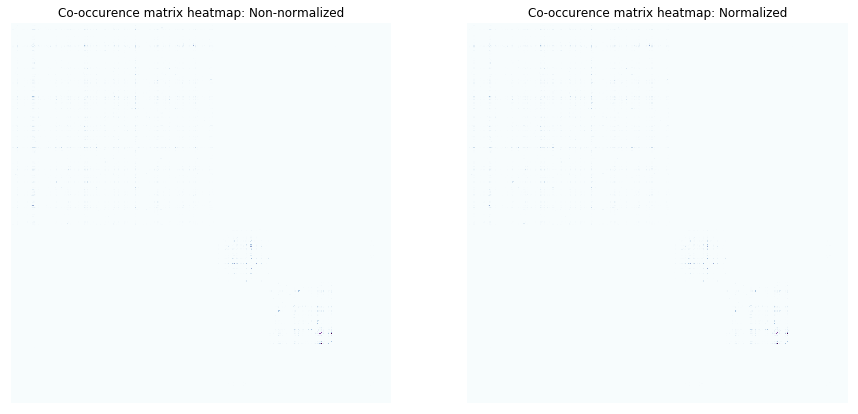

In [164]:
plt.subplots(2,1,figsize=(15,15))

plt.subplot(121)
sns.heatmap(matrix, cmap='BuPu', cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Non-normalized')

plt.subplot(122)
sns.heatmap(normalized_matrix, cmap='BuPu', cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Normalized')
plt.show()

## 2. Co-occurence by country

In this part of the analysis, severall co-occurence matrixes will be produced. Ideally, one for every country in the database. 

### 2.1. A co-occurence matrix given a country

We start by getting a list of all of the countries in the neo4j database. 

In [165]:
country_query = """ MATCH (n:Country) 
                    WITH n.name AS Country 
                    RETURN Country;
                    """

country_names = list(set(DataFrame(connection_to_graph.data(country_query)).as_matrix()[:, 0]))
country_names.sort()

print 'The country list has {} countries.'.format(len(country_names))

The country list has 145 countries.


After doing this, we prepare a function that given a certain country, will retrieve the co-occurence matrix. 

In [166]:
def get_country_matrix(country, normalization=True):
    
    # define queries
    country_no_interestions = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.country = "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(country)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    country_intersections = """     MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.country = "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(country_no_interestions)).as_matrix()
    
    # create matrix
    country_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            country_matrix[pair[0], pair[1]] += frequency
            country_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(country_intersections.format(category, category, country))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                country_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                country_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    normalized_country_matrix = (country_matrix - np.mean(country_matrix)) / np.std(country_matrix)
    
    # dynamic return 
    if normalization == True:
        return normalized_country_matrix
    else: 
        return country_matrix

Let's create a function that returns basic stats given a matrix. 

In [167]:
def basic_stats(a_matrix):
    print 'Rows:', a_matrix.shape[0]
    print 'Columns:', a_matrix.shape[1]
    print 'Mean: ', np.mean(a_matrix)
    print 'Standart Deviation', np.std(a_matrix)
    print 'Max: ', np.amax(a_matrix)
    print 'Min: ', np.amin(a_matrix)
    print 'Symmetry: ', check_symmetric(matrix, 1e-8)
    print ''

Let's test a couple of countries. 

In [168]:
print 'Denmark co-occurence matrix stats:'
basic_stats(get_country_matrix('Denmark', normalization=True))
print 'Sweden co-occurence matrix stats:'
basic_stats(get_country_matrix('Sweden', normalization=True))

Denmark co-occurence matrix stats:
Rows: 342
Columns: 342
Mean:  2.2477070913378225e-17
Standart Deviation 1.0
Max:  98.71619845088439
Min:  -0.043307401534452276
Symmetry:  True

Sweden co-occurence matrix stats:
Rows: 342
Columns: 342
Mean:  7.046865475545606e-18
Standart Deviation 1.0
Max:  111.13602822340711
Min:  -0.06205868957115324
Symmetry:  True



### 2.1. Transforming the co-occurence matrix into a list

One of the goals of the analysis is to understand how each relates to another. To do this, we will need to transform the matrix of a given country into an array. After doing this we will be able to compare the array of each one of the countries, by computing their difference for example. 

Let's start by creating a function that given a symetric matrix, as the ones shown above, returns a list. This list will have an entry by position in the matrix. 

This means that for a matrix of dimensions 342x342 the list will have a total of 58 482 entries. 

In [169]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

### 2.2. Visualizing correlations

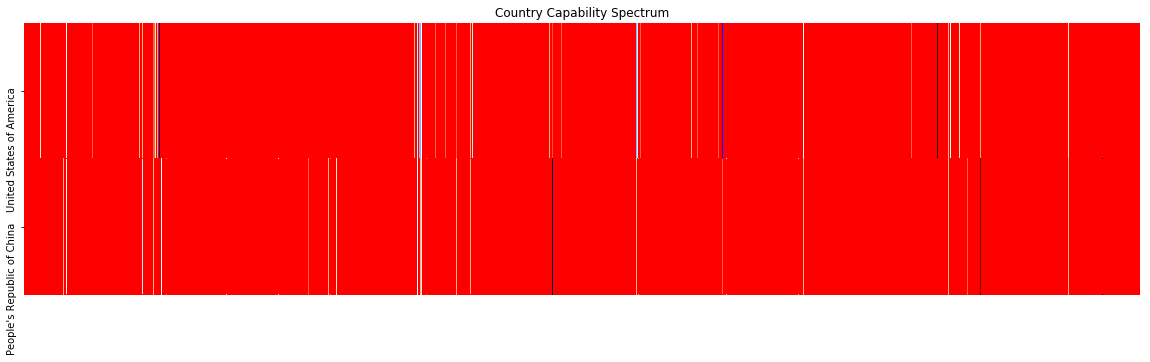

In [170]:
country_1_ = 'United States of America'
country_2_ = '''People's Republic of China'''

country_1_list = get_list_from(get_country_matrix(country_1_, normalization=True))
country_2_list = get_list_from(get_country_matrix(country_2_, normalization=True))

corelation = np.vstack((country_1_list, country_2_list))

plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='flag', cbar=None, square=False, yticklabels=[country_1_, country_2_], xticklabels=False)
plt.title('Country Capability Spectrum'.format(country_1_, country_2_))
plt.show()

We can see that the spectrum differs significantly in some areas. Please note that all of the measure were normalized prior to the plotting

### 2.3. Creating a correlation matrix

In this part of the analysis we will start correlating countries in relation to their capabilities. 

The correlation matrix follows the following principle: 
- Entry (i, j) is the correlation index between country i and country j
- The correlation index between country i and j is the absolute average difference between the capability list of country i and j.

Now, taking the list of countries previously established, we can iterate through it and fill the matrix. 

To improve efficieency, we first create a dictionnary where each key is a country, and each value, the capability list. Taking into consideration that if a country has no records, we will discard it. 

In [171]:
# create dictionnary
country_capability_dict = {}
counter = 0

# iterate through countries
for country in country_names:
    counter += 1
    country_matrix = get_country_matrix(country, normalization=True)
    
    if np.all(np.isnan(country_matrix)):
        continue
    else: 
        country_capability_dict[country] = get_list_from(country_matrix)

np.save('Data/country_capability_dict.npy', country_capability_dict) 

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



Let's create a function that given two countries and a method, returns a suitable correlation coeficient: 

In [172]:
from scipy import stats

def calculate_country_correlation(country1_list, country2_list, stat):
   
    avg_dif = np.mean(country1_list - country2_list)
    abs_avg_dif = abs(avg_dif)
    
    if stat.lower() == 'absolute average difference': # return absolute average difference
        return abs_avg_dif
    if stat == 'Pearson':                             # return Pearson coef
        return stats.pearsonr(country1_list, country2_list)[0]
    if stat == 'P-value':                             # return P-value
        return stats.pearsonr(country1_list, country2_list)[1]


We can now fill the matrix

In [173]:
country_names = country_capability_dict.keys()
country_names.sort()
number_of_countries = len(country_names)
country_correlation = np.zeros([number_of_countries, number_of_countries])

for row in range(number_of_countries):
    print 'Processing country {} / {} \r'.format(row + 1, number_of_countries),
    country_1 = country_names[row]
    country_1_list = np.asarray(country_capability_dict[country_1])
    for column in range(number_of_countries):
        country_2 = country_names[column]
        country_2_list = np.asarray(country_capability_dict[country_2])

        country_correlation[row, column] = calculate_country_correlation(country_1_list, country_2_list, 'Pearson')

np.save('Data/country_correlation.npy', country_correlation)
np.save('Data/country_names.npy', country_names)

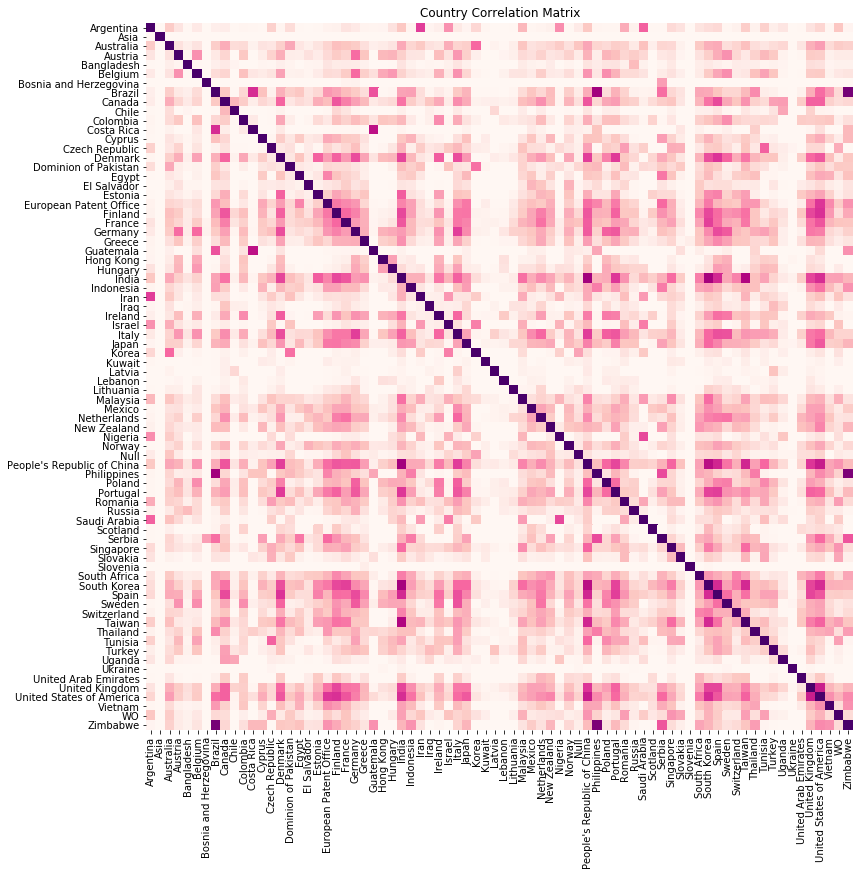

In [174]:
colors = ['RdPu'] # , 'BuPu' for other viz

for color in colors: 
    plt.subplots(1,1,figsize=(13, 13))
    plt.subplot(111)
    sns.heatmap(country_correlation, cmap='{}'.format(color), cbar=None, square=True, yticklabels=country_names, xticklabels=country_names)
    plt.title('Country Correlation Matrix')
    plt.show()

In this result, the darker the color in the heatmap, the more correlated the countries are. 

Let's try to cluster the matrix above in torder to provide a more fruitful visualization. Using a biclustering algorithm found in [SciKit](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.bicluster.SpectralBiclustering.html#sklearn.cluster.bicluster.SpectralBiclustering.fit)

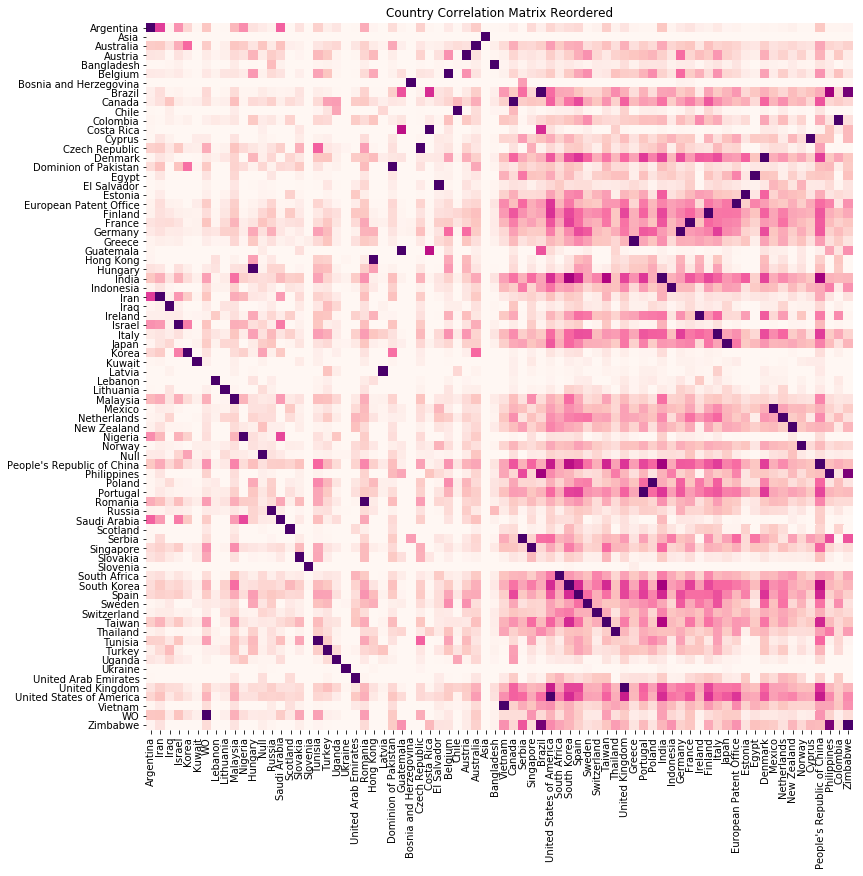

In [175]:
from sklearn.cluster.bicluster import SpectralBiclustering

# define number of clusters and method. 
n_clusters = (2, 2)
chosen_method = 'log'
# ‘scale’, ‘bistochastic’, or ‘log’, recommended is log but default is bistochastic

# fit model
model = SpectralBiclustering(n_clusters=n_clusters, method=chosen_method, random_state=0)
model.fit(country_correlation)

# create new matrix
fit_data = country_correlation[np.argsort(model.row_labels_)]
fit_data = country_correlation[:, np.argsort(model.column_labels_)]

# rearrange labels
idx = np.argsort(model.row_labels_)
names = np.asarray(country_names)

# plot
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(fit_data, cmap='RdPu', cbar=None, square=True, yticklabels=country_names, xticklabels=names[idx])
plt.title('Country Correlation Matrix Reordered')
plt.show()

#### 2.3.1. Plotly Visualizations

In [176]:
import plotly.plotly as py
from plotly.graph_objs import *


layout1 = {
  "title": "Country Capability Correlation: Biofuels", 
  "xaxis": {
    "autorange": True, 
    "range": [-0.5, 75.5], 
    "type": "category"
  }, 
  "yaxis": {
    "autorange": True, 
    "range": [75.5, -0.5], 
    "type": "category"
  }
}

trace1 = {
  "x": country_names, 
  "y": country_names,
  "z":country_correlation, 
"autocolorscale": False, 
  "colorscale": [
    [0, "rgb(46, 4, 149)"], [0.35, "rgb(142, 12, 163)"], [0.5, "rgb(205, 73, 117)"], [0.6, "rgb(243, 134, 71)"], [0.7, "rgb(250, 186, 32)"], [1, "rgb(249, 216, 36)"]],
  "showscale": True, 
  "type": "heatmap", 
  "uid": "6d08f4", 
  "xsrc": "duarteocarmo:1:b9d6c6", 
  "ysrc": "duarteocarmo:1:714ad2", 
  "zauto": True, 
  "zmax": 1, 
  "zmin": -0.0010633598613, 
  "zsrc": "duarteocarmo:1:-b9d6c6,714ad2"
}
data=[trace1]
fig = Figure(data=data, layout=layout1)
plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig)
#py.iplot(fig, filename='Country Correlation', sharing='public')

In [177]:
import plotly.plotly as py
from plotly.graph_objs import *


layout2 = {
  "title": "Country Capability Correlation Reordered: Biofuels", 
  "xaxis": {
    "autorange": True, 
    "range": [-0.5, 75.5], 
    "type": "category"
  }, 
  "yaxis": {
    "autorange": True, 
    "range": [75.5, -0.5], 
    "type": "category"
  }
}

trace2 = {
  "x": names[idx], 
  "y": country_names,
  "z":fit_data, 
"autocolorscale": False, 
  "colorscale": [
    [0, "rgb(46, 4, 149)"], [0.35, "rgb(142, 12, 163)"], [0.5, "rgb(205, 73, 117)"], [0.6, "rgb(243, 134, 71)"], [0.7, "rgb(250, 186, 32)"], [1, "rgb(249, 216, 36)"]],
  "showscale": True, 
  "type": "heatmap", 
  "uid": "6d08f4", 
  "xsrc": "duarteocarmo:1:b9d6c6", 
  "ysrc": "duarteocarmo:1:714ad2", 
  "zauto": True, 
  "zmax": 1, 
  "zmin": -0.0010633598613, 
  "zsrc": "duarteocarmo:1:-b9d6c6,714ad2"
}
data=[trace2]
fig = Figure(data=data, layout=layout2)
plotly.offline.iplot(fig)

### 2.4. Zooming into a particular country

Let's use a histogram to visualize the correlation of a country with the other countries. This can be thought of as 'Slicing' the matrix above. 

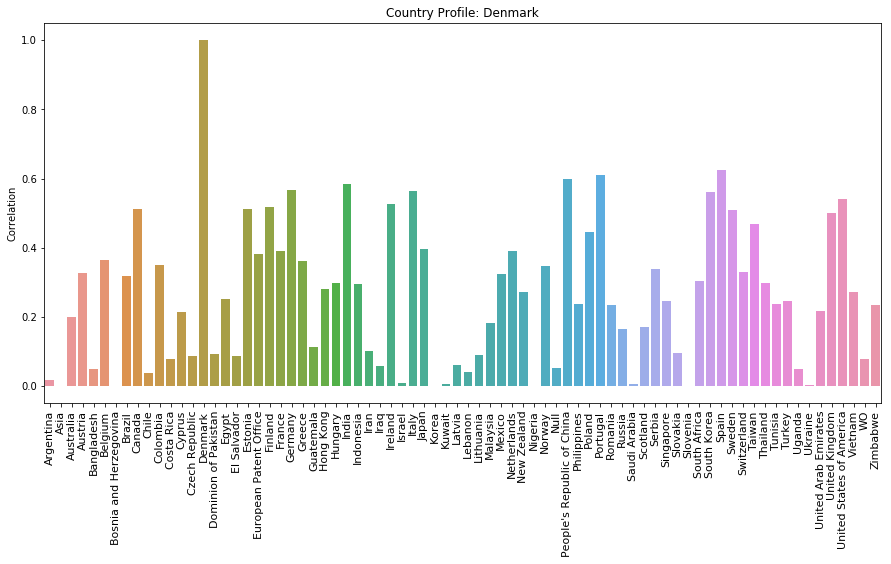

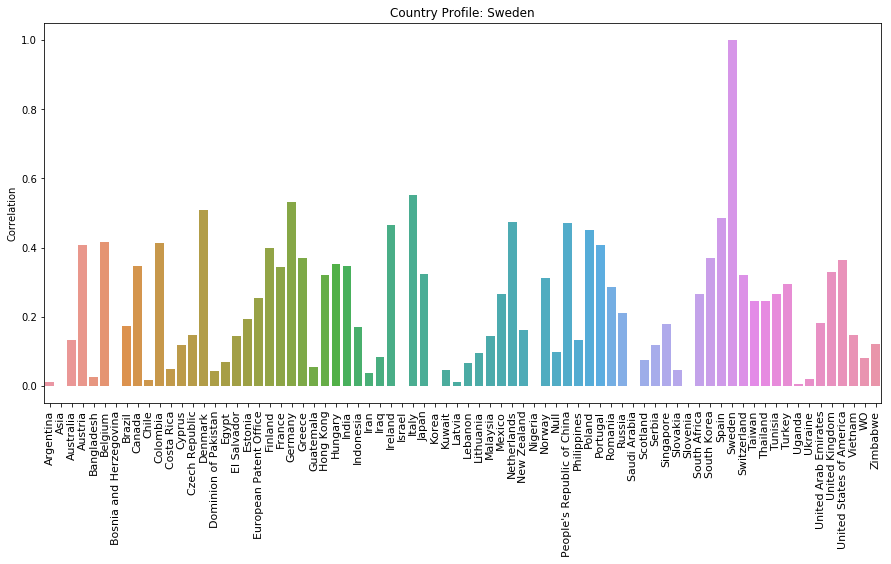

In [178]:
countries = ['Denmark', 'Sweden']

for country in countries:
    first_country_in_focus = country
    first_country_in_focus_index = find_index(first_country_in_focus, country_names)
    first_histogram_data = country_correlation[:, first_country_in_focus_index]
    
    plt.subplots(1,1,figsize=(15,7))
    sns.barplot(np.arange(len(first_histogram_data)), first_histogram_data)
    plt.xticks(np.arange(len(first_histogram_data)), country_names, rotation=90, fontsize=11)
    plt.title('Country Profile: {}'.format(first_country_in_focus))
    plt.ylabel('Correlation')
    plt.show()

In this result, the taller the bar, the more different the capabilities are. 

## 3. Contextual Relations

We will now study the relationship between the previously found correlations and other characteristics. 

Let's start with the GDP, in a database from the [IMF](http://www.imf.org/external/pubs/ft/weo/2017/02/weodata/weorept.aspx?pr.x=34&pr.y=13&sy=2017&ey=2017&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512%2C946%2C914%2C137%2C612%2C546%2C614%2C962%2C311%2C674%2C213%2C676%2C911%2C548%2C193%2C556%2C122%2C678%2C912%2C181%2C313%2C867%2C419%2C682%2C513%2C684%2C316%2C273%2C913%2C868%2C124%2C921%2C339%2C948%2C638%2C943%2C514%2C686%2C218%2C688%2C963%2C518%2C616%2C728%2C223%2C836%2C516%2C558%2C918%2C138%2C748%2C196%2C618%2C278%2C624%2C692%2C522%2C694%2C622%2C142%2C156%2C449%2C626%2C564%2C628%2C565%2C228%2C283%2C924%2C853%2C233%2C288%2C632%2C293%2C636%2C566%2C634%2C964%2C238%2C182%2C662%2C359%2C960%2C453%2C423%2C968%2C935%2C922%2C128%2C714%2C611%2C862%2C321%2C135%2C243%2C716%2C248%2C456%2C469%2C722%2C253%2C942%2C642%2C718%2C643%2C724%2C939%2C576%2C644%2C936%2C819%2C961%2C172%2C813%2C132%2C726%2C646%2C199%2C648%2C733%2C915%2C184%2C134%2C524%2C652%2C361%2C174%2C362%2C328%2C364%2C258%2C732%2C656%2C366%2C654%2C734%2C336%2C144%2C263%2C146%2C268%2C463%2C532%2C528%2C944%2C923%2C176%2C738%2C534%2C578%2C536%2C537%2C429%2C742%2C433%2C866%2C178%2C369%2C436%2C744%2C136%2C186%2C343%2C925%2C158%2C869%2C439%2C746%2C916%2C926%2C664%2C466%2C826%2C112%2C542%2C111%2C967%2C298%2C443%2C927%2C917%2C846%2C544%2C299%2C941%2C582%2C446%2C474%2C666%2C754%2C668%2C698%2C672&s=NGDPD&grp=0&a=#cs75§w)

We start by finding the countries in our databse that do not have GDP data available. 

In [179]:
data = pd.read_csv('Data/gdp.csv', delimiter=';', header=None).as_matrix()
for country in country_names:
    if country not in data[:, 0]:
        print country

Asia
European Patent Office
Null
Scotland
South Korea
WO


/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



After that, we delete those entries from the `country_correlation` matrix and create an `adapted_country_correlation`.

In [180]:
countries_not_available = ['Asia', 'European Patent Office', 'Korea', 'Null', 'Scotland', 'South Korea', 'WO']
index_countries_not_available = [find_index(country, country_names) for country in countries_not_available]

adapted_country_correlation = np.delete(country_correlation, index_countries_not_available, 0)
adapted_country_correlation = np.delete(adapted_country_correlation, index_countries_not_available, 1)


We create a matrix that correlates gdps

In [181]:
gdps = np.zeros([adapted_country_correlation.shape[0], adapted_country_correlation.shape[0]])
countries_available = [country for country in country_names if country not in countries_not_available]
countries_available.sort()

for row in range(len(countries_available)):
    country_1 = countries_available[row]
    country_1_gdp = float(data[find_index(country_1, data[:, 0].tolist()), 1])
    for column in range(len(countries_available)):
        country_2 = countries_available[column]
        country_2_gdp = float(data[find_index(country_2, data[:, 0].tolist()), 1])
    
        gdps[row, column] = abs(country_1_gdp - country_2_gdp)

gdps_norm = (gdps - np.mean(gdps)) / np.std(gdps)

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



We plot the GDP correlation matrix

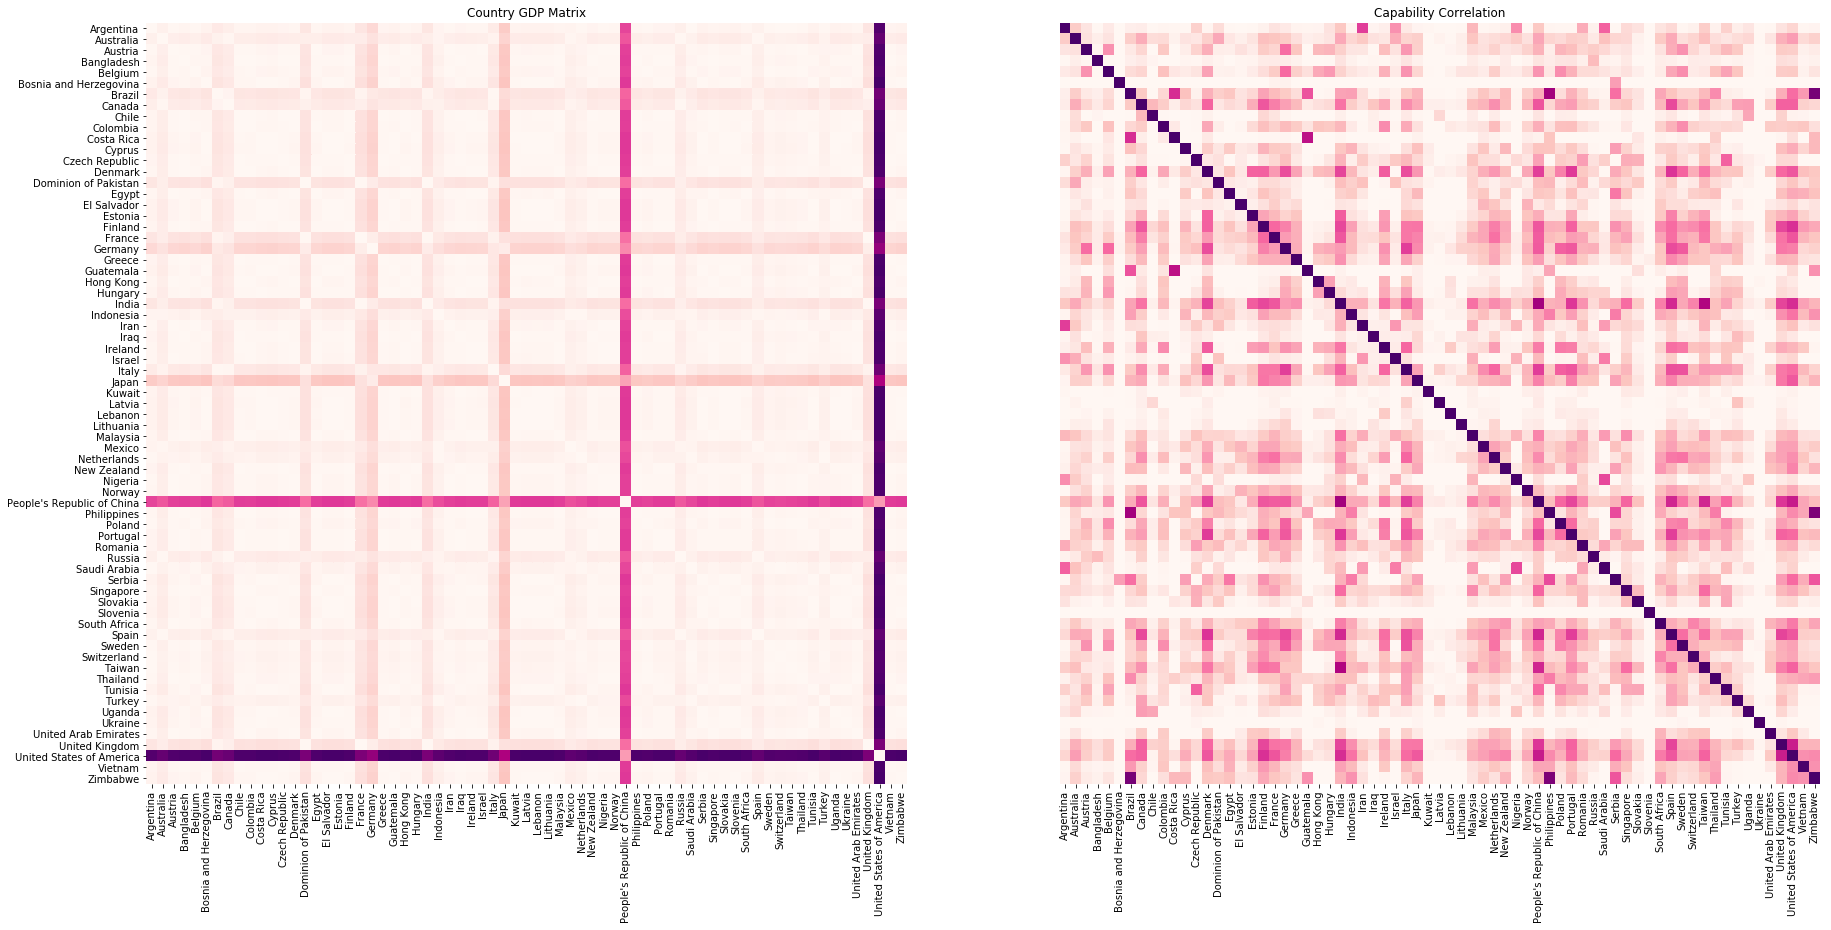

In [182]:

plt.subplots(2,1,figsize=(30,30))
plt.subplot(121)
sns.heatmap(gdps_norm, cmap='RdPu', cbar=None, square=True, yticklabels=countries_available, xticklabels=countries_available)
plt.title('Country GDP Matrix')

plt.subplot(122)
sns.heatmap(adapted_country_correlation, cmap='RdPu', cbar=None, square=True, xticklabels=countries_available, yticklabels=False)
plt.title('Capability Correlation')
plt.show()

